In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Optional

In [3]:
def calculate_period_end_dt(period_dt: pd.Series, time_level: str) -> pd.Series:
    if time_level == 'day':
        return period_dt
    elif time_level in ['week', 'week.2']:
        return period_dt + pd.offsets.Week(weekday=6)
    elif time_level == 'MONTH':
        return period_dt + pd.offsets.MonthEnd(0)
    else:
        raise ValueError(f"Unknown time_level: {time_level}")

def number_days(time_lvl: str, period_dt: pd.Timestamp) -> int:
    if time_lvl == 'day':
        return 1
    elif time_lvl in ['week', 'week.2']:
        return 7
    elif time_lvl == 'MONTH':
        return period_dt.days_in_month
    else:
        raise ValueError(f"Unknown time_lvl: {time_lvl}")


In [4]:
# Mid-term forecast creation
def create_mid_term_forecast(ts_forecast: pd.DataFrame, hist_end_dt: datetime, 
                           delays_config_length: int) -> pd.DataFrame:
    cutoff_date = hist_end_dt + timedelta(days=delays_config_length)
    
    mid_term = ts_forecast[ts_forecast['PERIOD_DT'] > cutoff_date].copy()
    
    if len(mid_term) > 0:
        mid_term['PERIOD_END_DT'] = mid_term['PERIOD_DT']  # PERIOD_DT as PERIOD_END_DT
        mid_term['TS_FORECAST_VALUE_REC'] = mid_term['FORECAST_VALUE']  # FORECAST_VALUE as TS_FORECAST_VALUE_REC
        mid_term['ML_FORECAST_VALUE'] = np.nan  # missing as ML_FORECAST_VALUE
        mid_term['DEMAND_TYPE'] = 'Regular'
        mid_term['ASSORTMENT_TYPE'] = 'old'
        
        # Add hierarchy columns if not present
        for col in ['product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id']:
            if col not in mid_term.columns:
                if col == 'product_lvl_id':
                    mid_term[col] = mid_term.get('PRODUCT_ID', 1)
                elif col == 'location_lvl_id':
                    mid_term[col] = mid_term.get('LOCATION_ID', 1)
                elif col == 'customer_lvl_id':
                    mid_term[col] = mid_term.get('CUSTOMER_ID', 1)
                elif col == 'distr_channel_lvl_id':
                    mid_term[col] = mid_term.get('DISTR_CHANNEL_ID', 1)
        
        # Remove original FORECAST_VALUE column
        mid_term = mid_term.drop(columns=['FORECAST_VALUE'], errors='ignore')
    
    return mid_term




In [5]:
# Join VF and ML forecasts
def join_vf_ml_forecasts(ts_forecast: pd.DataFrame, ml_forecast: pd.DataFrame,
                        hist_end_dt: datetime, delays_config_length: int,
                        ml_time_lvl: str = 'week.2', ts_time_lvl: str = 'day') -> pd.DataFrame:
    
    # Filter to short-term horizon
    cutoff_date = hist_end_dt + timedelta(days=delays_config_length)
    ts_short = ts_forecast[ts_forecast['PERIOD_DT'] <= cutoff_date].copy()
    ml_short = ml_forecast[ml_forecast['PERIOD_DT'] <= cutoff_date].copy()
    
    if len(ts_short) == 0 or len(ml_short) == 0:
        return pd.DataFrame()
    
    # Add PERIOD_END_DT
    ts_short['PERIOD_END_DT'] = calculate_period_end_dt(ts_short['PERIOD_DT'], ts_time_lvl)
    ml_short['PERIOD_END_DT'] = calculate_period_end_dt(ml_short['PERIOD_DT'], ml_time_lvl)
    
    # Rename forecast value columns for clarity
    ts_short = ts_short.rename(columns={'FORECAST_VALUE': 'TS_FORECAST_VALUE'})
    ml_short = ml_short.rename(columns={'FORECAST_VALUE_total': 'ML_FORECAST_VALUE'})
    
    # Perform overlap join
    joined_data = []
    
    for _, ml_row in ml_short.iterrows():
        for _, ts_row in ts_short.iterrows():
            # Check hierarchy matching and time overlap
            if (ml_row.get('PRODUCT_ID') == ts_row.get('PRODUCT_ID') and
                ml_row.get('LOCATION_ID') == ts_row.get('LOCATION_ID') and
                ml_row.get('CUSTOMER_ID', 1) == ts_row.get('CUSTOMER_ID', 1) and
                ml_row.get('DISTR_CHANNEL_ID', 1) == ts_row.get('DISTR_CHANNEL_ID', 1) and
                # Time overlap condition: ML.PERIOD_DT<=VF.PERIOD_END_DT and ML.PERIOD_END_DT>=VF.PERIOD_DT
                ml_row['PERIOD_DT'] <= ts_row['PERIOD_END_DT'] and
                ml_row['PERIOD_END_DT'] >= ts_row['PERIOD_DT']):
                
                # Calculate overlap period
                overlap_start = max(ml_row['PERIOD_DT'], ts_row['PERIOD_DT'])
                overlap_end = min(ml_row['PERIOD_END_DT'], ts_row['PERIOD_END_DT'])
                
                # Calculate proportional values
                overlap_days = (overlap_end - overlap_start).days + 1
                
                # TS_FORECAST_VALUE = TS_FORECAST_VALUE * [overlap_days] / number_days(ts_time_lvl, PERIOD_DT)
                ts_period_days = number_days(ts_time_lvl, ts_row['PERIOD_DT'])
                ts_proportional = ts_row['TS_FORECAST_VALUE'] * (overlap_days / ts_period_days)
                
                # ML_FORECAST_VALUE = ML_FORECAST_VALUE * [overlap_days] / number_days(ml_time_lvl, PERIOD_DT)
                ml_period_days = number_days(ml_time_lvl, ml_row['PERIOD_DT'])
                ml_proportional = ml_row['ML_FORECAST_VALUE'] * (overlap_days / ml_period_days)
                
                joined_data.append({
                    'product_lvl_id': ml_row.get('PRODUCT_ID'),
                    'location_lvl_id': ml_row.get('LOCATION_ID'),
                    'customer_lvl_id': ml_row.get('CUSTOMER_ID', 1),
                    'distr_channel_lvl_id': ml_row.get('DISTR_CHANNEL_ID', 1),
                    'PERIOD_DT': overlap_start,
                    'PERIOD_END_DT': overlap_end,
                    'TS_FORECAST_VALUE': ts_proportional,
                    'ML_FORECAST_VALUE': ml_proportional,
                    'DEMAND_TYPE': ml_row.get('DEMAND_TYPE', 'regular'),
                    'ASSORTMENT_TYPE': ml_row.get('ASSORTMENT_TYPE', 'old')
                })
    
    result_df = pd.DataFrame(joined_data)
    
    # Replace missing values with zero
    if len(result_df) > 0:
        result_df['TS_FORECAST_VALUE'].fillna(0, inplace=True)
        result_df['ML_FORECAST_VALUE'].fillna(0, inplace=True)
    
    return result_df




In [6]:
# Reconcile ML and VF Forecast
def reconcile_ml_vf_forecast(joined_df: pd.DataFrame) -> pd.DataFrame:
    if len(joined_df) == 0:
        return joined_df
        
    result_df = joined_df.copy()
    
    # Group by the specified dimensions
    grouping_cols = ['product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id', 'PERIOD_DT']
    
    def reconcile_group(group):
        ml_total = group['ML_FORECAST_VALUE'].sum()
        ts_total = group['TS_FORECAST_VALUE'].sum()
        
        if ts_total > 0:
            # TS_FORECAST_VALUE_REC = (TS_FORECAST_VALUE / ts_total) * ml_total
            group['TS_FORECAST_VALUE_REC'] = (group['TS_FORECAST_VALUE'] / ts_total) * ml_total
        else:
            # If no TS forecast, set reconciled value to 0
            group['TS_FORECAST_VALUE_REC'] = 0
            
        return group
    
    result_df = result_df.groupby(grouping_cols, group_keys=False).apply(reconcile_group)
    
    return result_df




In [7]:
# Add Segment Name
def add_segment_name(reconciled_df: pd.DataFrame, segments_df: pd.DataFrame) -> pd.DataFrame:
    if len(reconciled_df) == 0:
        return reconciled_df
        
    # Perform left join to add SEGMENT_NAME
    join_cols = ['product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id']
    
    # Ensure segments_df has the right column names
    segments_join = segments_df.copy()
    if 'PRODUCT_ID' in segments_join.columns:
        segments_join = segments_join.rename(columns={
            'PRODUCT_ID': 'product_lvl_id',
            'LOCATION_ID': 'location_lvl_id',
            'CUSTOMER_ID': 'customer_lvl_id',
            'DISTR_CHANNEL_ID': 'distr_channel_lvl_id'
        })
    
    # Add missing hierarchy levels if not present
    for col in join_cols:
        if col not in segments_join.columns:
            if col == 'customer_lvl_id':
                segments_join[col] = 1  # Default customer level
            elif col == 'distr_channel_lvl_id':
                segments_join[col] = 1  # Default distribution channel level
    
    # Perform the join
    result_df = pd.merge(reconciled_df, segments_join[join_cols + ['SEGMENT_NAME']], 
                        on=join_cols, how='left')
    
    return result_df




In [8]:
# Complete Pipeline
def forecast_reconciliation_pipeline(ts_forecast: pd.DataFrame, 
                                   ml_forecast: pd.DataFrame,
                                   segments_df: pd.DataFrame,
                                   hist_end_dt: datetime,
                                   delays_config_length: int = 30,
                                   ml_time_lvl: str = 'week.2',
                                   ts_time_lvl: str = 'day') -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    #Create mid-term forecast
    mid_term_forecast = create_mid_term_forecast(ts_forecast, hist_end_dt, delays_config_length)
    
    #Join VF and ML forecasts
    joined = join_vf_ml_forecasts(ts_forecast, ml_forecast, hist_end_dt, delays_config_length,
                                 ml_time_lvl, ts_time_lvl)
    
    #Reconcile ML and VF Forecast
    reconciled = reconcile_ml_vf_forecast(joined)
    
    # Add Segment Name
    final_reconciled = add_segment_name(reconciled, segments_df)
    
    return final_reconciled, mid_term_forecast




In [9]:
#2. Import/Generation of Data

# Configuration parameters
np.random.seed(42)  # For reproducibility

IB_HIST_END_DT = datetime(2024, 6, 15)  # Last known date (historical data end)
delays_config_length = 30  # Length of short-term forecasting period

# Generate date ranges
start_date = IB_HIST_END_DT + timedelta(days=1)
end_date = start_date + timedelta(days=60)  # 60 days forecast horizon
dates = pd.date_range(start_date, end_date, freq='D')

# Product and location hierarchy levels
products = [101, 102, 103, 104, 105]
locations = [1, 2, 3]
customers = [1, 2]  
distr_channels = [1]  





In [10]:
# Create TS_FORECAST data
ts_data = []
for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                base_demand = np.random.randint(80, 150)
                for date in dates:
                    seasonal_factor = 1 + 0.2 * np.sin(2 * np.pi * date.dayofyear / 365)
                    noise = np.random.normal(1, 0.1)
                    
                    ts_value = base_demand * seasonal_factor * noise
                    ts_data.append({
                        'PRODUCT_ID': product,
                        'LOCATION_ID': location,  
                        'CUSTOMER_ID': customer,
                        'DISTR_CHANNEL_ID': distr_channel,
                        'PERIOD_DT': date,
                        'FORECAST_VALUE': max(0, ts_value)  # Correct column name from document
                    })

ts_forecast = pd.DataFrame(ts_data)
ts_forecast.head()


,PRODUCT_ID,LOCATION_ID,CUSTOMER_ID,DISTR_CHANNEL_ID,PERIOD_DT,FORECAST_VALUE
0,101,1,1,1,2024-06-16,122.186745
1,101,1,1,1,2024-06-17,141.404053
2,101,1,1,1,2024-06-18,140.405792
3,101,1,1,1,2024-06-19,149.911281
4,101,1,1,1,2024-06-20,127.826794


In [11]:
ml_data = []

# ML forecast is more sparse - subset of products/locations, weekly granularity
selected_products = [101, 102, 104]  # Only some products have ML forecasts
selected_locations = [1, 2]          # Only some locations
selected_customers = [1]             # Subset of customers
demand_types = ['regular', 'promo']
assortment_types = ['old', 'new']

for product in selected_products:
    for location in selected_locations:
        for customer in selected_customers:
            for distr_channel in distr_channels:
                base_demand = np.random.randint(600, 1000)  # Weekly base demand
                # Generate weekly forecasts (every 7 days) - ml_time_lvl = 'week.2'
                for i in range(0, len(dates), 7):
                    if i < len(dates):
                        date = dates[i]
                        ml_factor = np.random.uniform(0.8, 1.3)
                        noise = np.random.normal(1, 0.15)
                        
                        ml_value = base_demand * ml_factor * noise
                        ml_data.append({
                            'PRODUCT_ID': product,
                            'LOCATION_ID': location,
                            'CUSTOMER_ID': customer,
                            'DISTR_CHANNEL_ID': distr_channel,
                            'PERIOD_DT': date,
                            'FORECAST_VALUE_total': max(0, ml_value),  # Correct column name from document
                            'FORECAST_VALUE_baseline': max(0, ml_value * 0.8),
                            'DEMAND_TYPE': np.random.choice(demand_types),
                            'ASSORTMENT_TYPE': np.random.choice(assortment_types)
                        })

ml_forecast = pd.DataFrame(ml_data)
ml_forecast.head()


,PRODUCT_ID,LOCATION_ID,CUSTOMER_ID,DISTR_CHANNEL_ID,PERIOD_DT,FORECAST_VALUE_total,FORECAST_VALUE_baseline,DEMAND_TYPE,ASSORTMENT_TYPE
0,101,1,1,1,2024-06-16,889.605310,711.684248,regular,new
1,101,1,1,1,2024-06-23,787.373753,629.899003,promo,old
2,101,1,1,1,2024-06-30,808.889542,647.111634,promo,new
3,101,1,1,1,2024-07-07,550.960137,440.768109,promo,old
4,101,1,1,1,2024-07-14,630.934267,504.747414,promo,new


In [12]:
segments_data = []
segment_names = ['Premium', 'Standard', 'Economy', 'Luxury', 'Budget']

for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                segment = np.random.choice(segment_names)
                segments_data.append({
                    'PRODUCT_ID': product,     
                    'LOCATION_ID': location,   
                    'CUSTOMER_ID': customer,   
                    'DISTR_CHANNEL_ID': distr_channel,  
                    'SEGMENT_NAME': segment
                })

ts_segments = pd.DataFrame(segments_data)
ts_segments.head()


,PRODUCT_ID,LOCATION_ID,CUSTOMER_ID,DISTR_CHANNEL_ID,SEGMENT_NAME
0,101,1,1,1,Luxury
1,101,1,2,1,Budget
2,101,2,1,1,Economy
3,101,2,2,1,Premium
4,101,3,1,1,Luxury


In [13]:
# Results
short_term_reconciled, mid_term_forecast = forecast_reconciliation_pipeline(
    ts_forecast=ts_forecast,
    ml_forecast=ml_forecast,
    segments_df=ts_segments,
    hist_end_dt=IB_HIST_END_DT,
    delays_config_length=delays_config_length,
    ml_time_lvl='week.2',
    ts_time_lvl='day'
)

print(f"Short-term reconciled: {len(short_term_reconciled)} records")
print(f"Mid-term forecast: {len(mid_term_forecast)} records")

if len(short_term_reconciled) > 0:
    short_term_reconciled.head()


/var/folders/9b/9c97gn7117zdvjgpkhjmc_jw0000gn/T/ipykernel_5011/3797017560.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['TS_FORECAST_VALUE'].fillna(0, inplace=True)
/var/folders/9b/9c97gn7117zdvjgpkhjmc_jw0000gn/T/ipykernel_5011/3797017560.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Short-term reconciled: 204 records
Mid-term forecast: 930 records


/var/folders/9b/9c97gn7117zdvjgpkhjmc_jw0000gn/T/ipykernel_5011/34816233.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby(grouping_cols, group_keys=False).apply(reconcile_group)


In [14]:
short_term_cutoff = IB_HIST_END_DT + timedelta(days=delays_config_length)

if len(short_term_reconciled) > 0:
    grouping_cols = ['product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id', 'PERIOD_DT']
    
    accuracy_results = []
    for name, group in short_term_reconciled.groupby(grouping_cols):
        ml_total = group['ML_FORECAST_VALUE'].sum()
        rec_total = group['TS_FORECAST_VALUE_REC'].sum()
        
        if ml_total > 0:
            accuracy = abs(ml_total - rec_total) / ml_total
            accuracy_results.append(accuracy)
    
    if accuracy_results:
        avg_accuracy = np.mean(accuracy_results)
        print(f"Average reconciliation error: {avg_accuracy:.6f}")
        print(f"Perfect reconciliation groups: {sum(1 for x in accuracy_results if x < 1e-10)}")
        print(f"Total groups: {len(accuracy_results)}")


Average reconciliation error: 0.000000
Perfect reconciliation groups: 180
Total groups: 180


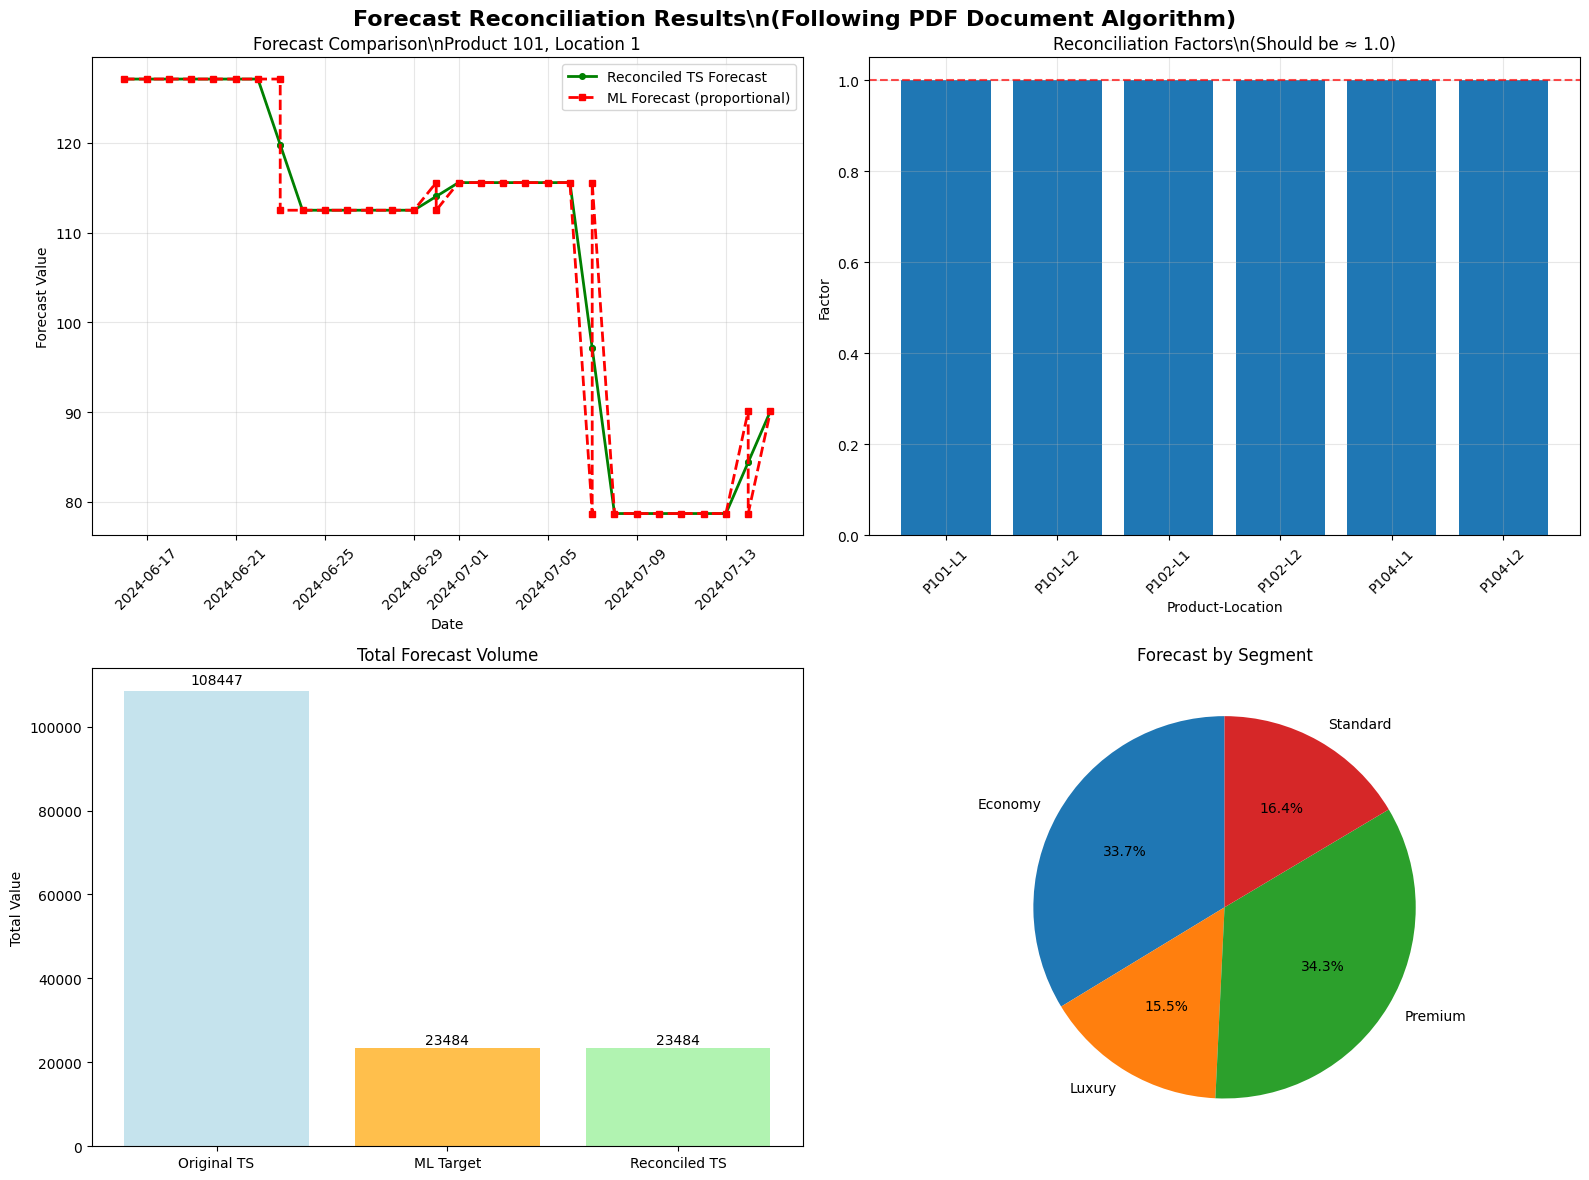

In [15]:
# Create comprehensive visualizations
if len(short_term_reconciled) > 0:
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Forecast Reconciliation Results\\n(Following PDF Document Algorithm)', 
                 fontsize=16, fontweight='bold')

    # 1. Time series comparison
    ax1 = axes[0, 0]
    sample_product = short_term_reconciled['product_lvl_id'].iloc[0]
    sample_location = short_term_reconciled['location_lvl_id'].iloc[0]
    
    rec_sample = short_term_reconciled[
        (short_term_reconciled['product_lvl_id'] == sample_product) & 
        (short_term_reconciled['location_lvl_id'] == sample_location)
    ].copy().sort_values('PERIOD_DT')
    
    if len(rec_sample) > 0:
        ax1.plot(rec_sample['PERIOD_DT'], rec_sample['TS_FORECAST_VALUE_REC'], 
                'g-', label='Reconciled TS Forecast', linewidth=2, marker='o', markersize=4)
        ax1.plot(rec_sample['PERIOD_DT'], rec_sample['ML_FORECAST_VALUE'], 
                'r--', label='ML Forecast (proportional)', linewidth=2, marker='s', markersize=4)
        
        ax1.set_title(f'Forecast Comparison\\nProduct {sample_product}, Location {sample_location}')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Forecast Value')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

    # 2. Reconciliation factors
    ax2 = axes[0, 1]
    reconciliation_stats = short_term_reconciled.groupby(['product_lvl_id', 'location_lvl_id']).agg({
        'ML_FORECAST_VALUE': 'sum',
        'TS_FORECAST_VALUE_REC': 'sum'
    }).reset_index()
    
    reconciliation_stats['Factor'] = (
        reconciliation_stats['TS_FORECAST_VALUE_REC'] / 
        reconciliation_stats['ML_FORECAST_VALUE'].replace(0, np.nan)
    )
    
    valid_stats = reconciliation_stats.dropna(subset=['Factor'])
    if len(valid_stats) > 0:
        x_labels = [f"P{int(row['product_lvl_id'])}-L{int(row['location_lvl_id'])}" 
                   for _, row in valid_stats.iterrows()]
        ax2.bar(range(len(valid_stats)), valid_stats['Factor'])
        ax2.set_title('Reconciliation Factors\\n(Should be ≈ 1.0)')
        ax2.set_xlabel('Product-Location')
        ax2.set_ylabel('Factor')
        ax2.set_xticks(range(len(valid_stats)))
        ax2.set_xticklabels(x_labels, rotation=45)
        ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7)
        ax2.grid(True, alpha=0.3)

    # 3. Volume comparison
    ax3 = axes[1, 0] 
    short_term_cutoff = IB_HIST_END_DT + timedelta(days=delays_config_length)
    ts_short_period = ts_forecast[ts_forecast['PERIOD_DT'] <= short_term_cutoff]
    
    total_ts_original = ts_short_period['FORECAST_VALUE'].sum()
    total_ml = short_term_reconciled['ML_FORECAST_VALUE'].sum()
    total_rec = short_term_reconciled['TS_FORECAST_VALUE_REC'].sum()
    
    categories = ['Original TS', 'ML Target', 'Reconciled TS']
    values = [total_ts_original, total_ml, total_rec]
    colors = ['lightblue', 'orange', 'lightgreen']
    
    bars = ax3.bar(categories, values, color=colors, alpha=0.7)
    ax3.set_title('Total Forecast Volume')
    ax3.set_ylabel('Total Value')
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.0f}', ha='center', va='bottom')

    # 4. Segment distribution
    ax4 = axes[1, 1]
    if 'SEGMENT_NAME' in short_term_reconciled.columns:
        segment_totals = short_term_reconciled.groupby('SEGMENT_NAME')['TS_FORECAST_VALUE_REC'].sum()
        
        if len(segment_totals) > 0:
            ax4.pie(segment_totals.values, labels=segment_totals.index, 
                   autopct='%1.1f%%', startangle=90)
            ax4.set_title('Forecast by Segment')

    plt.tight_layout()
    plt.show()
    plt.show()

else:
    print("No reconciled data available for visualization")


In [16]:
print("Summary:")
print(f"Mid-term forecast: {len(mid_term_forecast)} records")
print(f"Short-term reconciled: {len(short_term_reconciled)} records")

structure_checks = [
    ("TS_FORECAST", "FORECAST_VALUE", 'FORECAST_VALUE' in ts_forecast.columns),
    ("ML_FORECAST", "FORECAST_VALUE_total", 'FORECAST_VALUE_total' in ml_forecast.columns),
    ("ML_FORECAST", "DEMAND_TYPE", 'DEMAND_TYPE' in ml_forecast.columns),
    ("TS_SEGMENTS", "SEGMENT_NAME", 'SEGMENT_NAME' in ts_segments.columns),
]

for table, check, status in structure_checks:
    print(f"{table}: {check} - {'OK' if status else 'Missing'}")

if len(short_term_reconciled) > 0:
    output_checks = [
        ("product_lvl_id", 'product_lvl_id' in short_term_reconciled.columns),
        ("TS_FORECAST_VALUE_REC", 'TS_FORECAST_VALUE_REC' in short_term_reconciled.columns),
        ("ML_FORECAST_VALUE", 'ML_FORECAST_VALUE' in short_term_reconciled.columns),
        ("SEGMENT_NAME", 'SEGMENT_NAME' in short_term_reconciled.columns),
        ("DEMAND_TYPE", 'DEMAND_TYPE' in short_term_reconciled.columns),
    ]
    
    for check, status in output_checks:
        print(f"Output {check}: {'OK' if status else 'Missing'}")


Summary:
Mid-term forecast: 930 records
Short-term reconciled: 204 records
TS_FORECAST: FORECAST_VALUE - OK
ML_FORECAST: FORECAST_VALUE_total - OK
ML_FORECAST: DEMAND_TYPE - OK
TS_SEGMENTS: SEGMENT_NAME - OK
Output product_lvl_id: OK
Output TS_FORECAST_VALUE_REC: OK
Output ML_FORECAST_VALUE: OK
Output SEGMENT_NAME: OK
Output DEMAND_TYPE: OK
